<a href="https://colab.research.google.com/github/OIEIEIO/supreme-octo-chainsaw/blob/main/clean_jean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup for DALLE - Tesla P100 recommended 

In [27]:
#@title Check for Available Resources 
#@markdown - number of CPU 
#@markdown - amount of RAM
#@markdown - check for GPU
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 2
RAM GB: 12.7
PyTorch version: 1.10.0+cu111
CUDA version: 11.1
cuDNN version: 8005
device: cuda
Mon Feb 28 06:21:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    35W / 250W |  14745MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------

In [29]:
#@title pip install
#@markdown - rudalle 1.0.0
#@markdown - ruclip 0.0.1rc7
#@markdown - translators 4.9.5
!pip install rudalle==1.0.0 > /dev/null
!pip install ruclip==0.0.1rc7 > /dev/null
!pip install translators==4.9.5 > /dev/null

In [22]:
#@title Import
#@markdown - translators
#@markdown - ruclip
#@markdown - imageio
import translators
import ruclip
import imageio
from rudalle.pipelines import generate_images, show, super_resolution, cherry_pick_by_ruclip
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan
from rudalle.utils import seed_everything

In [23]:
#@title Download pretrained model for CUDA
#@markdown - Malevich 1.3 billion params
device = 'cuda'
dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)

◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.


In [24]:
#@title Realesrgran - Increase Image resolution
#@markdown - x2 
#@markdown - x4
#@markdown - x8
realesrgan = get_realesrgan('x4', device=device) # x2/x4/x8
tokenizer = get_tokenizer()
vae = get_vae(dwt=True).to(device)  # for stable generations you should use dwt=False
clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)
clip_predictor = ruclip.Predictor(clip, processor, device, bs=8)

x4 --> ready
tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready


## Image generation by DALLE

In [25]:
#@title Translator - English to Russian - very basic translator
#@markdown - options for changing input languange 
def simple_detect_lang(text):
    if len(set('абвгдежзийклмнопрстуфхцчшщъыьэюяё').intersection(text.lower())) > 0:
        return 'ru'
    if len(set('abcdefghijklmnopqrstuvwxyz').intersection(text.lower())) > 0:
        return 'en'
    return 'other'

In [26]:
#@title Image Generator - this takes approximately - 10 minutes 
#@markdown - this generator was written in the Russian language
#@markdown - therefore image results are more accurate if the text prompt entry is done in the Russian language
#@markdown - do not use the English text for inference
#@markdown - you should use translation to Russian, or you can use directly Russian text 
#@markdown - here you can adjust number of images to output - default is set to - 24

#@markdown

text = 'a log cabin on a beautiful lake' # @param 

#@markdown

if simple_detect_lang(text) != 'ru':
    text = translators.google(text, from_language='en', to_language='ru')
print('text:', text)

seed_everything(42)

pil_images = []
ppl_scores = []
for top_k, top_p, images_num in [
    (2048, 0.995, 24),
]:
    _pil_images, _ppl_scores = generate_images(text, tokenizer, dalle, vae, top_k=top_k, images_num=images_num, top_p=top_p, bs=8)
    pil_images += _pil_images
    ppl_scores += _ppl_scores

prediction_images = list(zip(pil_images, ppl_scores))
print(len(prediction_images))
    

/usr/local/lib/python3.7/dist-packages/translators/apis.py:117: UserWarning: Did not get a complete language map. And do not use `from_language="auto"`.
  warnings.warn('Did not get a complete language map. And do not use `from_language="auto"`.')


text: бревенчатая кабина на красивом озере


  0%|          | 0/1024 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rudalle/dalle/model.py:89: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=self.device) // self.image_tokens_per_dim


  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

24


In [30]:
#@title Saving images
#@markdown - saved images are in numerical order   
# Сохраняем изображения
for i, (image, score) in enumerate(prediction_images):
    image.save(f'{i}.png')

In [31]:
#@title Create an animation - you can adjust frame rate
#@markdown - default is set to fps=1 - one frame per second - represents one image per second
#@markdown - as an example 24 images at 1 fps produces at 15 second GIF  
#@markdown - outputs a file called 'animated.gif' 

images = [imageio.imread(f'{i}.png') for i in range(len(prediction_images))]
imageio.mimsave('animation.gif', images, fps=1)

In [ ]:
#@title Rendering the animation - GIF
#@markdown - when the rendering is conplete the GIF will autoplay below
import io
import base64
from IPython.display import HTML

video = io.open('animation.gif', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

In [16]:
#@title Delete the generated pics and animated gif
#@markdown - Removes the 24 pics and the animated gif
#@markdown - you may want to do this for a fresh run - otherwise it will overwrite older images 
import os
for i in range(len(prediction_images)):
    os.remove(f'{i}.png')

os.remove('animation.gif')

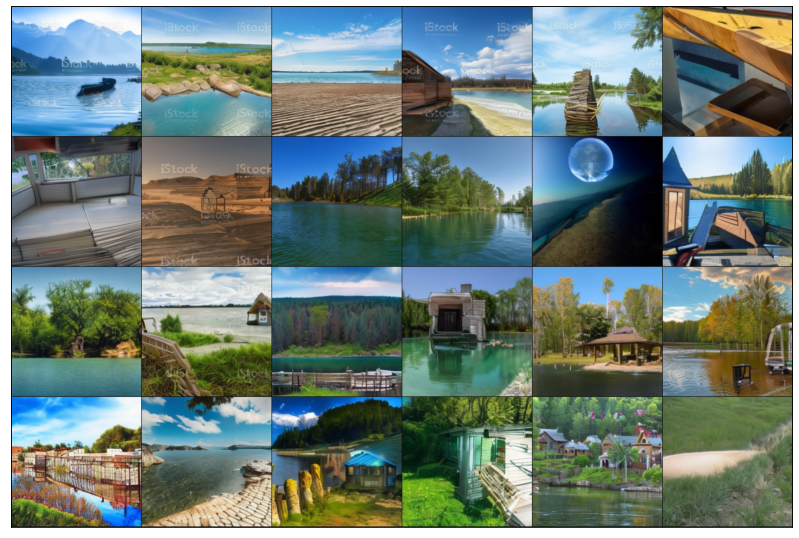

In [33]:
#@title View created images
#@markdown - creates a collage with 24 images - 6 columns - 4 rows 
#@markdown - image created displays below
show(pil_images, 6)

24it [00:00, 128.46it/s]


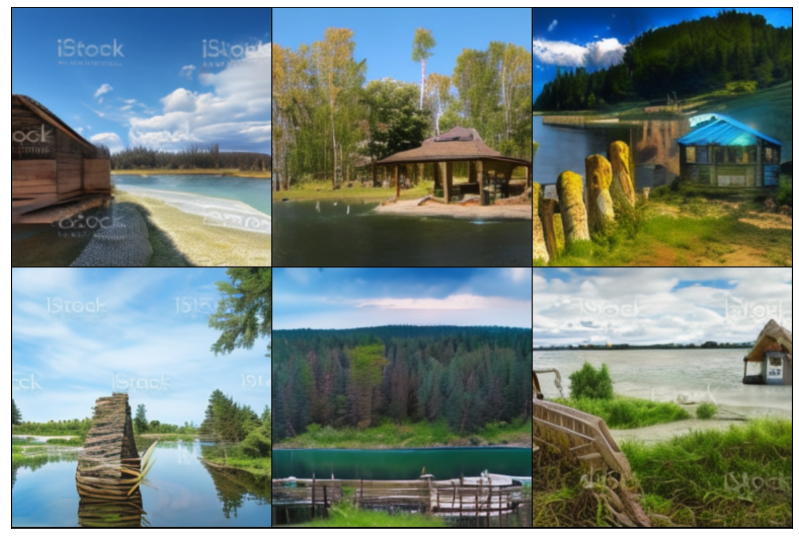

In [34]:
#@title Auto Cherry Pick - View Created images
#@markdown - selects 6 of the 24 
#@markdown - image created displays below
top_images, clip_scores = cherry_pick_by_ruclip(pil_images, text, clip_predictor, count=6)
show(top_images, 3)

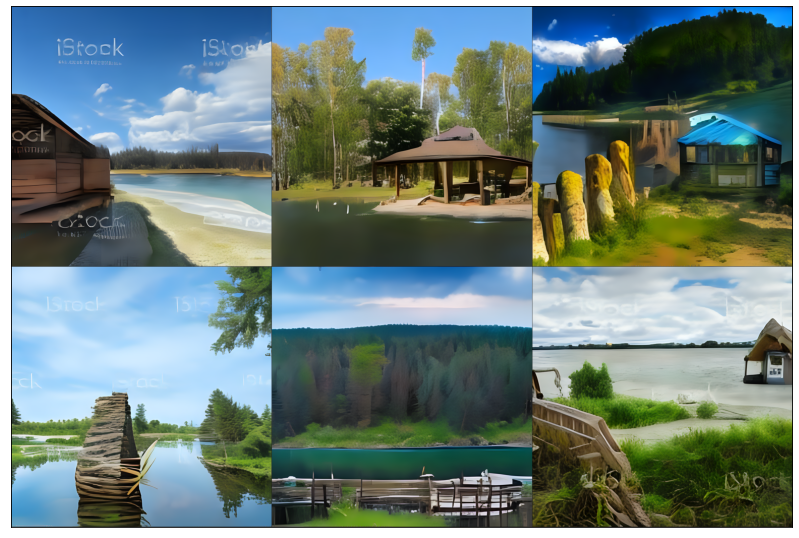

In [35]:
#@title Super Resolution
#@markdown - enhances auto cherry pick collage image resolution 
#@markdown - image created displays below
sr_images = super_resolution(top_images, realesrgan)
show(sr_images, 3)

In [ ]:
# Save images to disk
for i, img in enumerate(pil_images):
    img.save('{}.png'.format(i))
